In [79]:
import warnings
import glob
import math
from os.path import join
from datetime import time, datetime

import numpy as np
import scipy.ndimage
import matplotlib.pyplot as plt
from skimage.draw import polygon
import SimpleITK as sitk
import pydicom as pdcm
from pydicom.tag import Tag


In [52]:
# SUV conversion code taken from HECKTOR repo

def get_physical_values_pt(slices, patient_weight, dtype=np.float32):
    s = slices[0]
    units = s.Units
    if units == 'BQML':
        print("Units in BQML")
        acquisition_datetime = datetime.strptime(
            s[Tag(0x00080022)].value + s[Tag(0x00080032)].value.split('.')[0],
            "%Y%m%d%H%M%S")
        serie_datetime = datetime.strptime(
            s[Tag(0x00080021)].value + s[Tag(0x00080031)].value.split('.')[0],
            "%Y%m%d%H%M%S")

        try:
            if (serie_datetime <= acquisition_datetime) and (
                    serie_datetime > datetime(1950, 1, 1)):
                scan_datetime = serie_datetime
            else:
                scan_datetime_value = s[Tag(0x0009100d)].value
                if isinstance(scan_datetime_value, bytes):
                    scan_datetime_str = scan_datetime_value.decode(
                        "utf-8").split('.')[0]
                elif isinstance(scan_datetime_value, str):
                    scan_datetime_str = scan_datetime_value.split('.')[0]
                else:
                    raise ValueError(
                        "The value of scandatetime is not handled")
                scan_datetime = datetime.strptime(scan_datetime_str,
                                                  "%Y%m%d%H%M%S")

            start_time_str = s.RadiopharmaceuticalInformationSequence[
                0].RadiopharmaceuticalStartTime
            start_time = time(int(start_time_str[0:2]),
                              int(start_time_str[2:4]),
                              int(start_time_str[4:6]))
            start_datetime = datetime.combine(scan_datetime.date(), start_time)
            decay_time = (scan_datetime - start_datetime).total_seconds()
        except KeyError:
            warnings.warn("Estimation of time decay for SUV"
                          " computation from average parameters")
            decay_time = 1.75 * 3600  # From Martin's code
        return get_suv_from_bqml(slices,
                                 decay_time,
                                 patient_weight,
                                 dtype=dtype)

    elif units == 'CNTS':
        print("Units in CNTS")
        return get_suv_philips(slices, dtype=dtype)
    else:
        raise ValueError('The {} units is not handled'.format(units))


def get_suv_philips(slices, dtype=np.float32):
    image = list()
    suv_scale_factor_tag = Tag(0x70531000)
    for s in slices:
        im = (float(s.RescaleSlope) * s.pixel_array +
              float(s.RescaleIntercept)) * float(s[suv_scale_factor_tag].value)
        image.append(im)
    return np.stack(image, axis=-1).astype(dtype)


def get_suv_from_bqml(slices, decay_time, patient_weight, dtype=np.float32):
    # Get SUV from raw PET
    image = list()
    for s in slices:
        pet = float(s.RescaleSlope) * s.pixel_array + float(s.RescaleIntercept)
        half_life = float(
            s.RadiopharmaceuticalInformationSequence[0].RadionuclideHalfLife)
        total_dose = float(
            s.RadiopharmaceuticalInformationSequence[0].RadionuclideTotalDose)
        decay = 2**(-decay_time / half_life)
        actual_activity = total_dose * decay

        im = pet * patient_weight * 1000 / actual_activity
        image.append(im)
    return np.stack(image, axis=-1).astype(dtype)


In [ ]:
# Custom viz class

class NdimageVisualizer():
    def __init__(self):
        # Everything in sitk (W,H,D) format
        self.spacing = (1.0, 1.0, 3.0)

        self.suv_window = {'level':1, 'width':3}
        self.hu_window = {'level':0, 'width':300}

        self.cmap_dict = {'PET': 'plasma', 'CT': 'gray', 'labelmap': 'gray', 'normalized': 'gray'}
        self.dpi = 80

    def set_spacing(self, spacing):
        self.spacing = spacing
    
    def set_suv_window(self, window):
        self.suv_window = window

    def set_hu_window(self, window):
        self.hu_window = window

    def _custom_imshow(self, ax, image, title, image_type):
        # Apply window
        if image_type == 'labelmap' or image_type == 'normalized':
            ax.imshow(image, cmap=self.cmap_dict[image_type])

        else:
            if image_type == 'PET':
                window = self.suv_window
            elif image_type == 'CT':
                window = self.hu_window
            win_min = window['level'] - window['width'] // 2
            win_max = window['level'] + window['width'] // 2
            ax.imshow(image, cmap=self.cmap_dict[image_type], vmin=win_min, vmax=win_max)

        ax.set_title(title)
        ax.axis('off')


    def multi_image_strips(self, image_np_list, image_types, idx_range, view='axial', subtitles=[], title=""):
        array_size = image_np_list[0].shape
        phy_size = [int(array_size[i]*self.spacing[i]) for i in range(3)]

        n_images = len(image_np_list)
        figsize = (n_images*450)/self.dpi, ((idx_range[1]-idx_range[0])*450)/self.dpi
        fig, axs = plt.subplots(1, n_images, figsize=figsize)

        if len(subtitles) != n_images: subtitles = image_types

        if view == 'axial':
            for i, image_np in enumerate(image_np_list):
                slice_list = []
                for j, s in enumerate(range(*idx_range)):
                    axial_slice = image_np[:, :, s].T
                    slice_list.append(axial_slice)
                strip = np.concatenate(slice_list, axis=0)
                self._custom_imshow(axs[i], strip, title=subtitles[i], image_type=image_types[i])

        if view == 'coronal':
            for i, image_np in enumerate(image_np_list):
                slice_list = []
                for j, s in enumerate(range(*idx_range)):
                    coronal_slice = image_np[:, s, :]
                    coronal_slice = scipy.ndimage.rotate(coronal_slice, 90)
                    coronal_slice = np.flip(coronal_slice, axis=1)
                    coronal_slice = scipy.ndimage.zoom(coronal_slice, [self.spacing[2], self.spacing[0]], order=1)
                    slice_list.append(coronal_slice)
                strip = np.concatenate(slice_list, axis=0)
                self._custom_imshow(axs[i], strip, title=subtitles[i], image_type=image_types[i])

        if view == 'sagittal':
            for i, image_np in enumerate(image_np_list):
                slice_list = []
                for s in range(*idx_range):
                    sagittal_slice = image_np[s, :, :]
                    sagittal_slice = scipy.ndimage.rotate(sagittal_slice, 90)
                    sagittal_slice = scipy.ndimage.zoom(sagittal_slice, [self.spacing[2], self.spacing[1]], order=1)
                    slice_list.append(sagittal_slice)
                strip = np.concatenate(slice_list, axis=0)
                self._custom_imshow(axs[i], strip, title=subtitles[i], image_type=image_types[i])

        # Display
        fig.suptitle(title, fontsize='x-large')
        plt.show()


    def grid(self, image_np, idx_range, view='axial', image_type='PET', title=''):
        array_size = image_np.shape
        phy_size = [int(array_size[i]*self.spacing[i]) for i in range(3)]
        w_phy, h_phy, d_phy = phy_size

        grid_size = (
                     5,
                     math.ceil((idx_range[1]-idx_range[0]) / 5)
                    )

        if view == 'axial':  grid_image_shape = (h_phy * grid_size[0], w_phy * grid_size[1])
        elif view == 'coronal': grid_image_shape = (d_phy * grid_size[0], w_phy* grid_size[1])
        elif view == 'sagittal': grid_image_shape = (d_phy * grid_size[0], h_phy* grid_size[1])

        grid_image = np.zeros(grid_image_shape)
        slice_list = []

        if view == 'axial':
            for s in range(*idx_range):
                axial_slice = image_np[:, :, s].T
                axial_slice = scipy.ndimage.zoom(axial_slice, [self.spacing[0], self.spacing[1]], order=1)
                slice_list.append(axial_slice)
            for gj in range(0, grid_size[1]):
                if gj != grid_size[1] - 1:
                    strip = np.concatenate(slice_list[gj*5:gj*5+5], axis=0)
                else:
                    strip = np.concatenate(slice_list[gj*5:], axis=0)
                grid_image[0:strip.shape[0], gj*w_phy : gj*w_phy+w_phy] = strip


        if view == 'coronal':
            for s in range(*idx_range):
                coronal_slice = image_np[:, s, :]
                coronal_slice = scipy.ndimage.rotate(coronal_slice, 90)
                coronal_slice = np.flip(coronal_slice, axis=1)
                coronal_slice = scipy.ndimage.zoom(coronal_slice, [self.spacing[2], self.spacing[0]], order=1)
                slice_list.append(coronal_slice)
            for gj in range(0, grid_size[1]):
                if gj != grid_size[1] - 1:
                    strip = np.concatenate(slice_list[gj*5:gj*5+5], axis=0)
                else:
                    strip = np.concatenate(slice_list[gj*5:], axis=0)
                grid_image[0:strip.shape[0], gj*w_phy : gj*w_phy+w_phy] = strip

        if view == 'sagittal':
            for s in range(*idx_range):
                sagittal_slice = image_np[s, :, :]
                sagittal_slice = scipy.ndimage.rotate(sagittal_slice, 90)
                sagittal_slice = scipy.ndimage.zoom(sagittal_slice, [self.spacing[2], self.spacing[1]], order=1)
                slice_list.append(sagittal_slice)
            for gj in range(0, grid_size[1]):
                if gj != grid_size[1] - 1:
                    strip = np.concatenate(slice_list[gj*5:gj*5+5], axis=0)
                else:
                    strip = np.concatenate(slice_list[gj*5:], axis=0)
                grid_image[0:strip.shape[0], gj*h_phy : gj*h_phy+h_phy] = strip

        # Display
        figsize = (5*400)/self.dpi, ((idx_range[1]-idx_range[0])/5*400)/self.dpi
        fig, ax = plt.subplots(figsize=figsize)
        self._custom_imshow(ax, grid_image, title=title, image_type=image_type)
        plt.show()


## Config

In [164]:
DATA_ROOT_DIR = "/home/chinmay/Datasets/HX4-PET-Translation"
SAMPLE_PATIENT = "N047"

## FDG-PET

In [165]:
# DICOM to numpy

input_filepaths = sorted(glob.glob(f"{DATA_ROOT_DIR}/{SAMPLE_PATIENT}/FDG/PT/*"))
fdg_pet_slices = [pdcm.read_file(dcm) for dcm in input_filepaths]
fdg_pet_slices = fdg_pet_slices[1:]
fdg_pet_slices.sort(key=lambda x: float(x.ImagePositionPatient[2]))

patient_weight = float(fdg_pet_slices[0].PatientWeight)
fdg_pet_np = get_physical_values_pt(fdg_pet_slices,
                                  patient_weight,
                                  dtype=np.float32)
fdg_pet_np = fdg_pet_np.transpose(1,0,2) # HWD to WHD

print(fdg_pet_np.shape, fdg_pet_np.min(), fdg_pet_np.max())

Units in BQML
(168, 168, 132) 0.0 23.512028


(4, 4, 3)


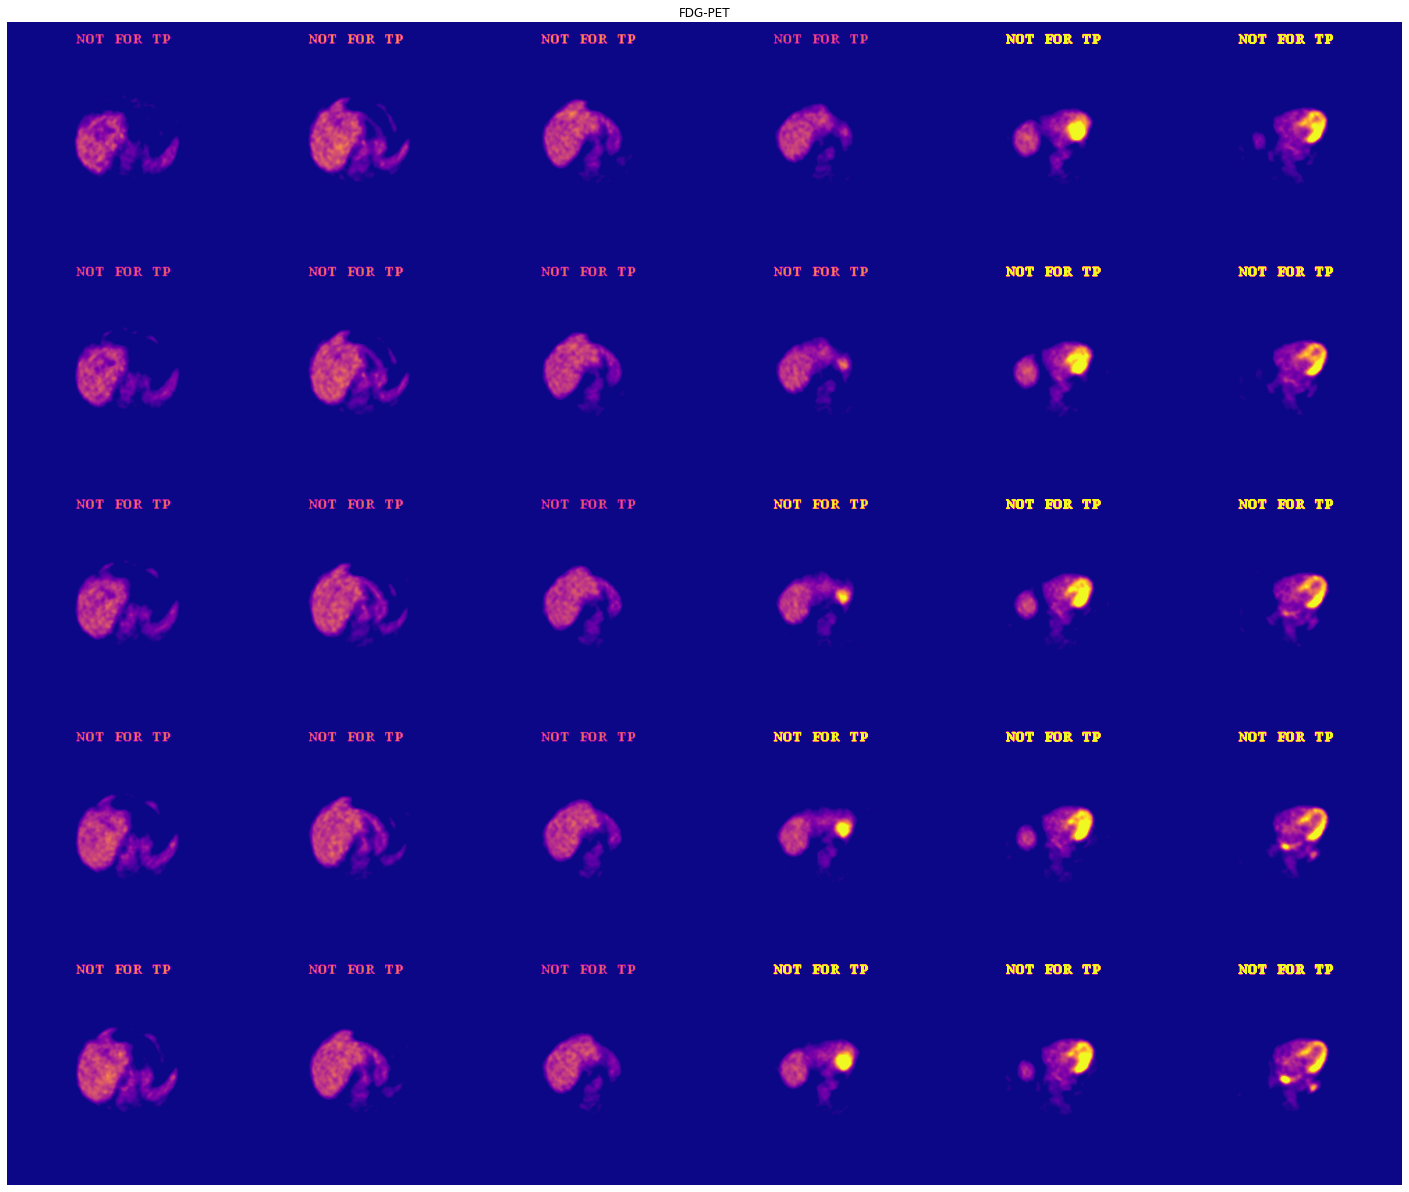

In [166]:
# Visualize

visualizer = NdimageVisualizer()

slice_spacing = fdg_pet_slices[1].ImagePositionPatient[2] - fdg_pet_slices[0].ImagePositionPatient[2]
spacing = (round(fdg_pet_slices[0].PixelSpacing[0]), round(fdg_pet_slices[0].PixelSpacing[1]), round(slice_spacing))
visualizer.set_spacing(spacing)
print(spacing)

visualizer.set_suv_window({'level':3, 'width':5})

visualizer.grid(fdg_pet_np, idx_range=[10,40], view='axial', image_type='PET', title="FDG-PET")

## HX4-PET

In [167]:
# DICOM to numpy

input_filepaths = sorted(glob.glob(f"{DATA_ROOT_DIR}/{SAMPLE_PATIENT}/HX4/PT/*"))
hx4_pet_slices = [pdcm.read_file(dcm) for dcm in input_filepaths]
hx4_pet_slices = hx4_pet_slices[1:]
hx4_pet_slices.sort(key=lambda x: float(x.ImagePositionPatient[2]))

patient_weight = float(hx4_pet_slices[0].PatientWeight)
hx4_pet_np = get_physical_values_pt(hx4_pet_slices,
                                  patient_weight,
                                  dtype=np.float32)
hx4_pet_np = hx4_pet_np.transpose(1,0,2) # HWD to WHD

print(hx4_pet_np.shape, hx4_pet_np.min(), hx4_pet_np.max())

Units in CNTS
(144, 144, 44) 0.0 3.051176


(4, 4, 4)


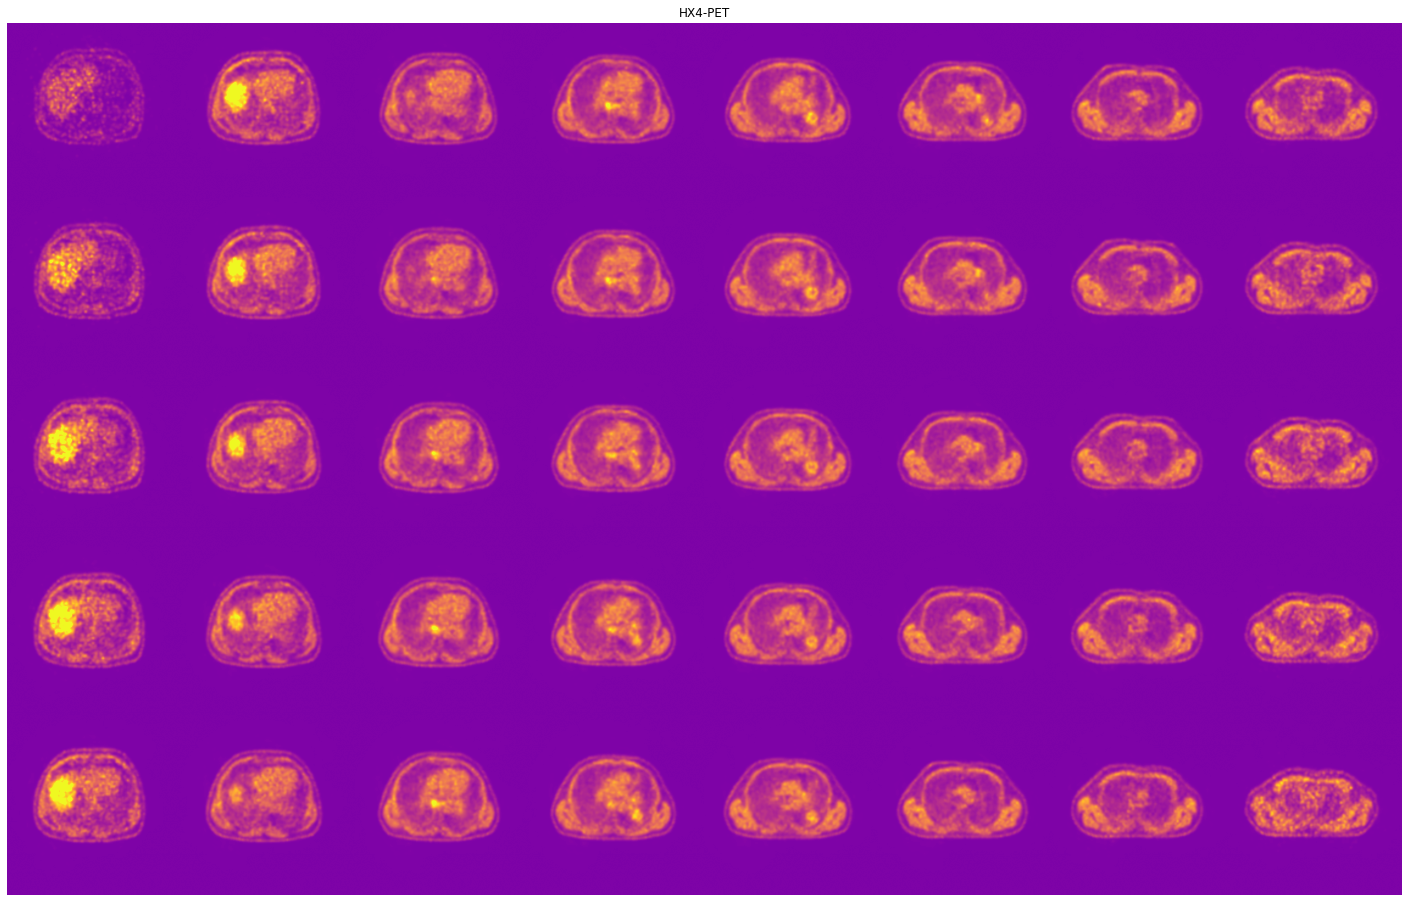

In [168]:
# Visualize
visualizer = NdimageVisualizer()

slice_spacing = hx4_pet_slices[1].ImagePositionPatient[2] - hx4_pet_slices[0].ImagePositionPatient[2]
spacing = (round(hx4_pet_slices[0].PixelSpacing[0]), round(hx4_pet_slices[0].PixelSpacing[1]), round(slice_spacing))
visualizer.set_spacing(spacing)
print(spacing)

visualizer.set_suv_window({'level':0.5, 'width':2})
visualizer.grid(hx4_pet_np, idx_range=[0,40], view='axial', image_type='PET', title="HX4-PET")

## HX4-PET-reg

In [169]:
# Read MHD/RAW file

hx4_pet_reg_sitk = sitk.ReadImage(f"{DATA_ROOT_DIR}/{SAMPLE_PATIENT}/reg_HX4_to_FDG/image_transformed/result.mhd", sitk.sitkFloat32)
hx4_pet_reg_np = sitk.GetArrayFromImage(hx4_pet_reg_sitk)

hx4_pet_reg_np = hx4_pet_reg_np.transpose(2,1,0)  # DHW to WHD 

print(hx4_pet_reg_np.shape, hx4_pet_reg_np.min(), hx4_pet_reg_np.max())

(144, 144, 45) -0.0056460067 2.7616746


(4.0, 4.0, 4.0)


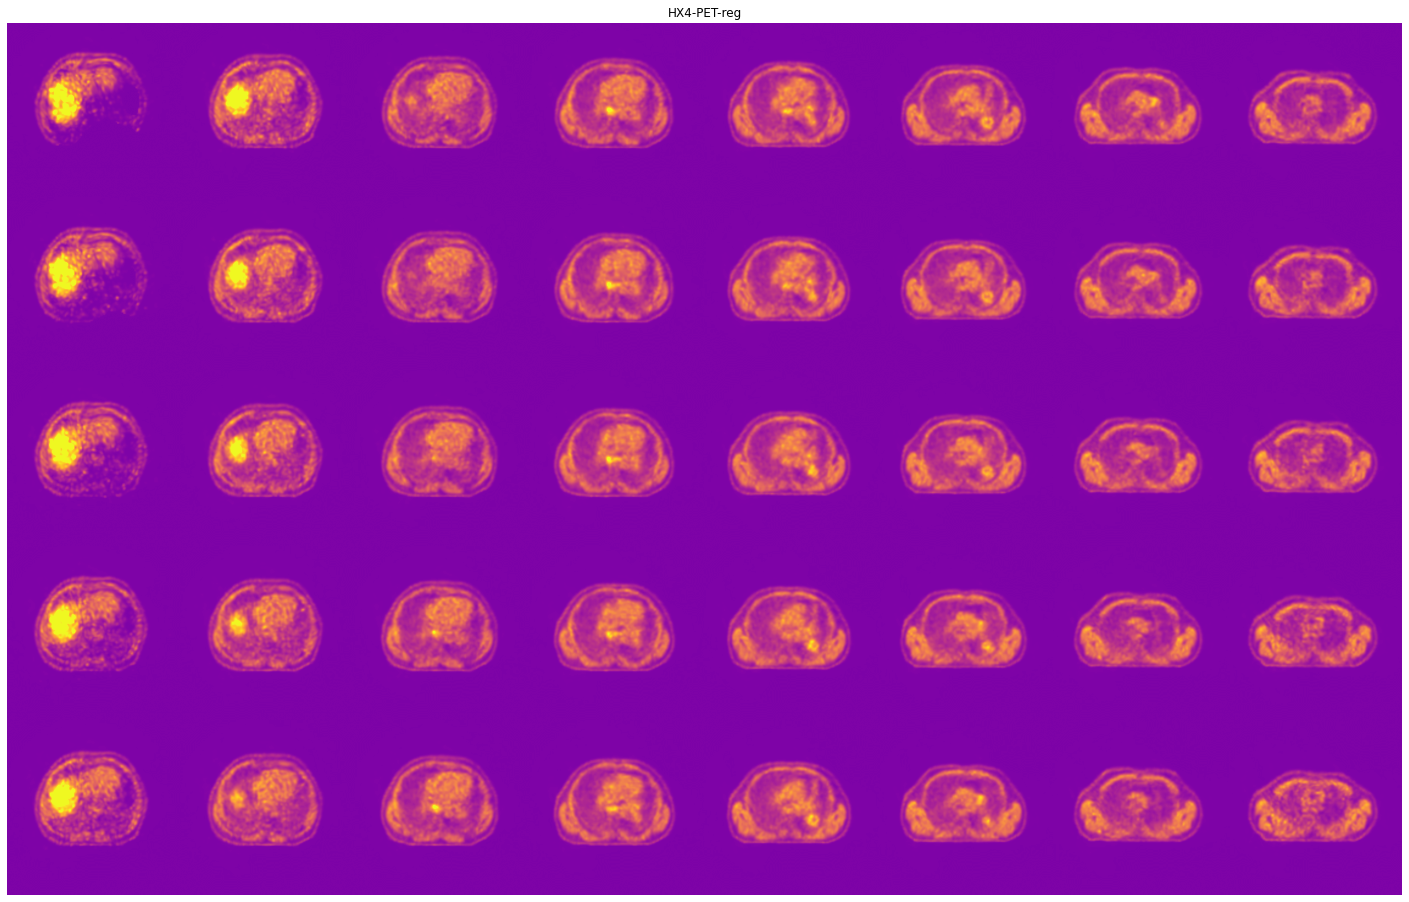

In [170]:
# Visualize 

visualizer = NdimageVisualizer()

spacing = hx4_pet_reg_sitk.GetSpacing()
visualizer.set_spacing(spacing)
print(spacing)

visualizer.set_suv_window({'level':0.5, 'width':2})
visualizer.grid(hx4_pet_reg_np, idx_range=[0,40], view='axial', image_type='PET', title="HX4-PET-reg")